In [1]:
import warnings
import datetime
import itertools
import numpy as np
import scipy as sp
import cvxpy as cp
import pandas as pd
import yfinance as yf
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from functools import reduce
from kit import interval_dict, annualize_returns, annualize_vol, get_yf_ts, gbm

warnings.filterwarnings('ignore')

<b>Momentum strategy</b> is a trading strategy that buys an asset when its price tends to go up and sells it when it tends to go down. The core idea is based on the observation that assets that have performed well in the past are likely to continue performing well in the near future, and those that have performed poorly are likely to continue underperforming.

Key components of the strategy are:
1. Selecting assets which to observe and invest in
2. Look back periods, assessing the trend of the strategy based on a particular time window in the past
3. Holding period, how long should one hold the asset before terminating the strategy
4. Risk management, such as a stop loss order to mitigate potential losses from abrupt reversals in momentum
5. Transaction costs (not included in my simulations), those often kill these strategies as it can be expensive to frequently rebalance
$$$$It is important to note that the trends observed are only empirical, and the increase of an asset price, in and of itself does not guarantee further increases. Momentums are technically market anomalies, where the asset price increases abnormally and investors using this strategy track assets during such periods before they correct to a previous value.

The most common type of a momentum strategy is built using moving averages. We construct 2 moving averages, one with longer period $w_1$ and one with shorter period $w_2$ and for the asset price $P$ if $\text{SMA}_{w_1}(P)<\text{SMA}_{w_2}(P)$ the strategy buys the asset, otherwise sells.

Such strategies are sometimes configured to have different holding periods for each action, to invest different amounts depending on the magnitude of the momentum etc. Below I am implementing a strategy that invests or sells a fixed amount (parametarized) everytime the condition of the strategy is satisfied, with the default of investing or selling-off the entire amount as the momentum signal flips.

In [441]:
def momentum_strategy(ticker, freq, period, w1, w2, h=1, init_inv=100, step_inv=0):
    df = get_yf_ts(ticker, period, freq)
    
    rf = get_yf_ts('^IRX', period, freq).rename(columns={'^IRX' : 'RF'})
    rf = (rf / 100).apply(np.log1p) / 360 # Risk-free return on the cash component
    
    c = df.rolling(w1).mean().merge(df.rolling(w2).mean(), left_index=True, right_index=True, suffixes=('_{}'.format(w1), '_{}'.format(w2))).dropna().merge(df, left_index=True, right_index=True).merge(rf, left_index=True, right_index=True)
    c['RETURN_STOCK'] = (1 + np.log(c[ticker] / c[ticker].shift(1))).rolling(h).apply(np.prod)
    c['RETURN_CASH'] = (1 + c['RF']).rolling(h).apply(np.prod) # Cumulative returns on the stock/cash for the duration of the holding period h
    c = c.dropna()
    
    cash, stock, cl, sl = init_inv, 0, [], []
    
    for x in c.to_dict(orient='records')[::h]: # We step each holding period h
        if x['{}_{}'.format(ticker, w1)] < x['{}_{}'.format(ticker, w2)]:
            if step_inv and cash > step_inv:
                stock += step_inv
                cash -= step_inv
            else:
                stock += cash
                cash = 0
        else:
            if step_inv and cash > step_inv:
                stock -= step_inv
                cash += step_inv
            else:
                cash += stock
                stock = 0 

        stock *= x['RETURN_STOCK']
        cash *= x['RETURN_CASH']
        
        sl.append(stock)
        cl.append(cash)
    c['STOCK'] = np.repeat(sl, h).tolist()[0 : c.shape[0]]
    c['CASH'] = np.repeat(cl, h).tolist()[0 : c.shape[0]]
    c['STRATEGY_WEALTH'] = c['STOCK'] + c['CASH']
    return c

In the below run, I only check a single stock (Apple) and backtest the strategy twice:
1. For the last 5 years, where the short moving average window is 2 weeks and the long window is 2 months with holding period of 1 week
2. For the last 2 years, where the short moving average window is 1 week and the long window is 1 month with holding period of 3 days

In [442]:
ms_5y = momentum_strategy('AAPL', '1d', '5y', 46, 10, 5, step_inv=0)
ms_2y = momentum_strategy('AAPL', '1d', '2y', 23, 5, 3, step_inv=0)

In [443]:
print("5y strategy return {}, Apple return {}.".format(*(ms_5y[['STRATEGY_WEALTH', 'AAPL']].iloc[-1] / ms_5y[['STRATEGY_WEALTH', 'AAPL']].iloc[0]).values))

5y strategy return 4.287878604387698, Apple return 3.664569783090176.


In [444]:
print("2y strategy return {}, Apple return {}.".format(*(ms_2y[['STRATEGY_WEALTH', 'AAPL']].iloc[-1] / ms_2y[['STRATEGY_WEALTH', 'AAPL']].iloc[0]).values))

2y strategy return 1.8397208700837993, Apple return 1.3774018675730235.


We observe that the strategy is around 30-40% more profitable than just investing the amount straight in Apple. The approach in these simulations is quite aggressive, where everytime the momentum factor no longer holds we sell-off the entire position in the stock and vice-versa. I included the step_inv parameter, where I allow to configure an amount that we buy/sell on each action from the strategy. This would make the overall strategy smoother (potentially less effective), but it'll be slower to pick up changes and it'll keep the investment in cash longer, unless the momentum signal is really persistent.

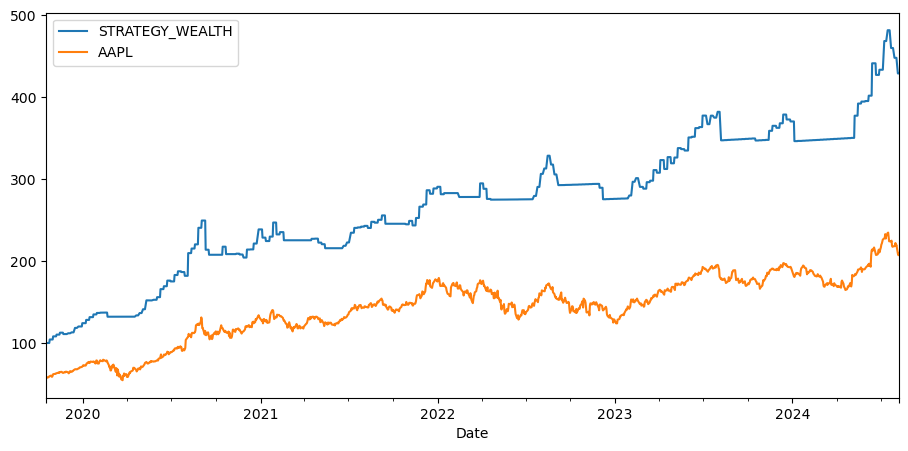

In [455]:
ms_5y[['STRATEGY_WEALTH', 'AAPL']].plot(figsize=(11,5))
plt.show()

To be continued: Mean reversion strategy, momentum strategy with stop loss risk management and transaction costs, relative strength strategy, sharpe ratios